## LGR with MVR and SFR

This script reproduces the model in Mehl and Hill (2013).

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl

import flopy
import flopy.utils.binaryfile as bf
import git
import matplotlib.pyplot as plt
import numpy as np
from flopy.plot.styles import styles
from flopy.utils.lgrutil import Lgr
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
example_name = "ex-gwf-lgr"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "meters"
time_units = "days"

# Model parameters
nlayp = 3  # Number of layers in parent model
nrowp = 15  # Number of rows in parent model
ncolp = 15  # Number of columns in parent model
delrp = 102.94  # Parent model column width ($m$)
delcp = 68.63  # Parent model row width ($m$)
dum1 = 5  # Number of child model columns per parent model columns
dum2 = 5  # Number of child model rows per parent model rows
dum3 = 20.588  # Child model column width ($m$)
dum4 = 13.725  # Child model row width ($m$)
k11 = 1.0  # Horizontal hydraulic conductivity ($m/d$)
k33 = 1.0  # Vertical hydraulic conductivity ($m/d$)

# Additional model input preparation
# Time related variables
delrp = 1544.1 / ncolp
delcp = 1029.4 / nrowp
numdays = 1
perlen = [1] * numdays
nper = len(perlen)
nstp = [1] * numdays
tsmult = [1.0] * numdays

# Further parent model grid discretization
x = [round(x, 3) for x in np.linspace(50.0, 45.0, ncolp)]
topp = np.repeat(x, nrowp).reshape((15, 15)).T
z = [round(z, 3) for z in np.linspace(50.0, 0.0, nlayp + 1)]
botmp = [topp - z[len(z) - 2], topp - z[len(z) - 3], topp - z[0]]
idomainp = np.ones((nlayp, nrowp, ncolp), dtype=int)
idomainp[0:2, 6:11, 2:8] = 0  # Zero out where the child grid will reside
icelltype = [1, 0, 0]  # Water table resides in layer 1

# Solver settings
nouter, ninner = 100, 300
hclose, rclose, relax = 1e-7, 1e-6, 0.97

# Prepping input for SFR package for parent model
# Define the connections
connsp = [
    (0, -1),
    (1, 0, -2),
    (2, 1, -3),
    (3, 2, -4),
    (4, 3, -5),
    (5, 4, -6),
    (6, 5, -7),
    (7, 6),
    (8, -9),
    (9, 8, -10),
    (10, 9, -11),
    (11, 10, -12),
    (12, 11, -13),
    (13, 12, -14),
    (14, 13, -15),
    (15, 14, -16),
    (16, 15, -17),
    (17, 16),
]

# Package_data information
sfrcells = [
    (0, 0, 1),
    (0, 1, 1),
    (0, 2, 1),
    (0, 2, 2),
    (0, 3, 2),
    (0, 4, 2),
    (0, 4, 3),
    (0, 5, 3),
    (0, 8, 8),
    (0, 8, 9),
    (0, 8, 10),
    (0, 8, 11),
    (0, 7, 11),
    (0, 7, 12),
    (0, 6, 12),
    (0, 6, 13),
    (0, 6, 14),
    (0, 5, 14),
]
rlen = [
    65.613029,
    72.488609,
    81.424789,
    35.850410,
    75.027390,
    90.887520,
    77.565651,
    74.860397,
    120.44695,
    112.31332,
    109.00368,
    91.234566,
    67.486000,
    24.603355,
    97.547943,
    104.97595,
    8.9454498,
    92.638367,
]
rwid = 5
rgrd1 = 0.12869035e-02
rgrd2 = 0.12780087e-02
rbtp = [
    49.409676,
    49.320812,
    49.221775,
    49.146317,
    49.074970,
    48.968212,
    48.859821,
    48.761742,
    45.550678,
    45.401943,
    45.260521,
    45.132568,
    45.031143,
    44.972298,
    44.894241,
    44.764832,
    44.692032,
    44.627121,
]
rbth = 1.5
rbhk = 0.1
man = 0.04
ustrf = 1.0
ndv = 0
pkdat = []
for i in np.arange(len(rlen)):
    if i < 8:
        rgrd = rgrd1
    else:
        rgrd = rgrd2
    ncon = len(connsp[i]) - 1
    pkdat.append(
        (
            i,
            sfrcells[i],
            rlen[i],
            rwid,
            rgrd,
            rbtp[i],
            rbth,
            rbhk,
            man,
            ncon,
            ustrf,
            ndv,
        )
    )

sfrspd = {0: [[0, "INFLOW", 40.0]]}

# Next, set up SFR input for the child model
# Start by defining the connections.  Set up with for loop since 1
# stream segment with all linear connections. Cheating a bit by the
# knowledge that there are 89 stream reaches in the child model.  This
# is known from the original model
connsc = []
for i in np.arange(89):
    if i == 0:
        connsc.append((i, -1 * (i + 1)))
    elif i == 88:
        connsc.append((i, i - 1))
    else:
        connsc.append((i, i - 1, -1 * (i + 1)))

# Package_data information
sfrcellsc = [
    (0, 0, 3),
    (0, 1, 3),
    (0, 1, 2),
    (0, 2, 2),
    (0, 2, 1),
    (0, 3, 1),
    (0, 4, 1),
    (0, 5, 1),
    (0, 6, 1),
    (0, 7, 1),
    (0, 7, 2),
    (0, 7, 3),
    (0, 7, 4),
    (0, 6, 4),
    (0, 5, 4),
    (0, 4, 4),
    (0, 3, 4),
    (0, 3, 5),
    (0, 3, 6),
    (0, 4, 6),
    (0, 4, 7),
    (0, 5, 7),
    (0, 5, 8),
    (0, 6, 8),
    (0, 7, 8),
    (0, 7, 7),
    (0, 8, 7),
    (0, 8, 6),
    (0, 8, 5),
    (0, 8, 4),
    (0, 9, 4),
    (0, 9, 3),
    (0, 10, 3),
    (0, 11, 3),
    (0, 12, 3),
    (0, 13, 3),
    (0, 13, 4),
    (0, 14, 4),
    (0, 14, 5),
    (0, 14, 6),
    (0, 13, 6),
    (0, 13, 7),
    (0, 12, 7),
    (0, 11, 7),
    (0, 11, 8),
    (0, 10, 8),
    (0, 9, 8),
    (0, 8, 8),
    (0, 7, 8),
    (0, 7, 9),
    (0, 6, 9),
    (0, 5, 9),
    (0, 4, 9),
    (0, 3, 9),
    (0, 2, 9),
    (0, 2, 10),
    (0, 1, 10),
    (0, 0, 10),
    (0, 0, 11),
    (0, 0, 12),
    (0, 0, 13),
    (0, 1, 13),
    (0, 2, 13),
    (0, 3, 13),
    (0, 4, 13),
    (0, 5, 13),
    (0, 6, 13),
    (0, 6, 12),
    (0, 7, 12),
    (0, 8, 12),
    (0, 9, 12),
    (0, 10, 12),
    (0, 11, 12),
    (0, 12, 12),
    (0, 12, 13),
    (0, 13, 13),
    (0, 13, 14),
    (0, 13, 15),
    (0, 12, 15),
    (0, 11, 15),
    (0, 10, 15),
    (0, 10, 16),
    (0, 9, 16),
    (0, 9, 15),
    (0, 8, 15),
    (0, 7, 15),
    (0, 6, 15),
    (0, 6, 16),
    (0, 6, 17),
]

rlenc = [
    24.637711,
    31.966246,
    26.376442,
    11.773884,
    22.921772,
    24.949730,
    23.878050,
    23.190311,
    24.762365,
    24.908625,
    34.366299,
    37.834534,
    6.7398176,
    25.150850,
    22.888292,
    24.630053,
    24.104542,
    35.873375,
    20.101446,
    35.636936,
    39.273537,
    7.8477302,
    15.480835,
    22.883194,
    6.6126003,
    31.995899,
    9.4387379,
    35.385513,
    35.470993,
    23.500074,
    18.414469,
    12.016913,
    24.691732,
    23.105467,
    23.700483,
    19.596104,
    5.7555680,
    34.423119,
    36.131992,
    7.4424477,
    35.565659,
    1.6159637,
    32.316132,
    20.131876,
    6.5242062,
    25.575630,
    25.575630,
    24.303566,
    1.9158504,
    21.931326,
    23.847176,
    23.432203,
    23.248718,
    23.455051,
    15.171843,
    11.196334,
    34.931976,
    4.4492774,
    36.034172,
    38.365566,
    0.8766859,
    30.059759,
    25.351671,
    23.554117,
    24.691738,
    26.074226,
    13.542957,
    13.303432,
    28.145079,
    24.373089,
    23.213642,
    23.298107,
    24.627758,
    27.715137,
    1.7645065,
    39.549232,
    37.144009,
    14.943290,
    24.851254,
    23.737432,
    15.967736,
    10.632832,
    11.425938,
    20.009295,
    24.641207,
    27.960585,
    4.6452723,
    36.717735,
    34.469074,
]
rwidc = 5
rgrdc = 0.14448310e-02
rbtpc = [
    48.622822,
    48.581932,
    48.539783,
    48.512222,
    48.487160,
    48.452576,
    48.417301,
    48.383297,
    48.348656,
    48.312775,
    48.269951,
    48.217793,
    48.185593,
    48.162552,
    48.127850,
    48.093521,
    48.058315,
    48.014984,
    47.974548,
    47.934284,
    47.880165,
    47.846127,
    47.829273,
    47.801556,
    47.780251,
    47.752357,
    47.722424,
    47.690044,
    47.638855,
    47.596252,
    47.565975,
    47.543991,
    47.517471,
    47.482941,
    47.449127,
    47.417850,
    47.399536,
    47.370510,
    47.319538,
    47.288059,
    47.256992,
    47.230129,
    47.205616,
    47.167728,
    47.148472,
    47.125282,
    47.088329,
    47.052296,
    47.033356,
    47.016129,
    46.983055,
    46.948902,
    46.915176,
    46.881439,
    46.853535,
    46.834484,
    46.801159,
    46.772713,
    46.743465,
    46.689716,
    46.661369,
    46.639019,
    46.598988,
    46.563660,
    46.528805,
    46.492130,
    46.463512,
    46.444118,
    46.414173,
    46.376232,
    46.341858,
    46.308254,
    46.273632,
    46.235821,
    46.214523,
    46.184677,
    46.129272,
    46.091644,
    46.062897,
    46.027794,
    45.999111,
    45.979897,
    45.963959,
    45.941250,
    45.908993,
    45.870995,
    45.847439,
    45.817558,
    45.766132,
]
rbthc = 1.5
rbhkc = 0.1
manc = 0.04
ustrfc = 1.0
ndvc = 0
pkdatc = []
for i in np.arange(len(rlenc)):
    nconc = len(connsc[i]) - 1
    pkdatc.append(
        (
            i,
            sfrcellsc[i],
            rlenc[i],
            rwidc,
            rgrdc,
            rbtpc[i],
            rbthc,
            rbhkc,
            manc,
            nconc,
            ustrfc,
            ndvc,
        )
    )

sfrspdc = {0: [[0, "INFLOW", 0.0]]}

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models(sim_name, silent=False):
    # Instantiate the MODFLOW 6 simulation
    name = "lgr"
    gwfname = "gwf-" + name
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(
        sim_name=sim_name,
        version="mf6",
        sim_ws=sim_ws,
        exe_name="mf6",
        continue_=True,
    )

    # Instantiating MODFLOW 6 time discretization
    tdis_rc = []
    for i in range(len(perlen)):
        tdis_rc.append((perlen[i], nstp[i], tsmult[i]))
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)

    # Instantiating MODFLOW 6 groundwater flow model
    gwfname = gwfname + "-parent"
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfname,
        save_flows=True,
        newtonoptions="newton",
        model_nam_file=f"{gwfname}.nam",
    )

    # Instantiating MODFLOW 6 solver for flow model
    imsgwf = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwfname}.ims",
    )
    sim.register_ims_package(imsgwf, [gwf.name])

    # Instantiating MODFLOW 6 discretization package
    dis = flopy.mf6.ModflowGwfdis(
        gwf,
        nlay=nlayp,
        nrow=nrowp,
        ncol=ncolp,
        delr=delrp,
        delc=delcp,
        top=topp,
        botm=botmp,
        idomain=idomainp,
        filename=f"{gwfname}.dis",
    )

    # Instantiating MODFLOW 6 initial conditions package for flow model
    strt = [topp - 0.25, topp - 0.25, topp - 0.25]
    ic = flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{gwfname}.ic")

    # Instantiating MODFLOW 6 node-property flow package
    npf = flopy.mf6.ModflowGwfnpf(
        gwf,
        save_flows=False,
        alternative_cell_averaging="AMT-LMK",
        icelltype=icelltype,
        k=k11,
        k33=k33,
        save_specific_discharge=False,
        filename=f"{gwfname}.npf",
    )

    # Instantiating MODFLOW 6 output control package for flow model
    oc = flopy.mf6.ModflowGwfoc(
        gwf,
        budget_filerecord=f"{gwfname}.bud",
        head_filerecord=f"{gwfname}.hds",
        headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
        printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    )

    # Instantiating MODFLOW 6 constant head package
    rowList = np.arange(0, nrowp).tolist()
    layList = np.arange(0, nlayp).tolist()
    chdspd_left = []
    chdspd_right = []

    # Loop through rows, the left & right sides will appear in separate,
    # dedicated packages
    hd_left = 49.75
    hd_right = 44.75
    for l in layList:
        for r in rowList:
            # first, do left side of model
            chdspd_left.append([(l, r, 0), hd_left])
            # finally, do right side of model
            chdspd_right.append([(l, r, ncolp - 1), hd_right])

    chdspd = {0: chdspd_left}
    chd1 = flopy.mf6.modflow.mfgwfchd.ModflowGwfchd(
        gwf,
        maxbound=len(chdspd),
        stress_period_data=chdspd,
        save_flows=False,
        pname="CHD-1",
        filename=f"{gwfname}.chd1.chd",
    )
    chdspd = {0: chdspd_right}
    chd2 = flopy.mf6.modflow.mfgwfchd.ModflowGwfchd(
        gwf,
        maxbound=len(chdspd),
        stress_period_data=chdspd,
        save_flows=False,
        pname="CHD-2",
        filename=f"{gwfname}.chd2.chd",
    )

    # Instantiating MODFLOW 6 Parent model's SFR package
    sfr = flopy.mf6.ModflowGwfsfr(
        gwf,
        print_stage=False,
        print_flows=False,
        budget_filerecord=gwfname + ".sfr.bud",
        save_flows=True,
        mover=True,
        pname="SFR-parent",
        time_conversion=86400.0,
        boundnames=False,
        nreaches=len(connsp),
        packagedata=pkdat,
        connectiondata=connsp,
        perioddata=sfrspd,
        filename=f"{gwfname}.sfr",
    )

    # -------------------------------
    # Now pivoting to the child grid
    # -------------------------------
    # Leverage flopy's "Lgr" class; was imported at start of script
    ncpp = 3
    ncppl = [3, 3, 0]
    lgr = Lgr(
        nlayp,
        nrowp,
        ncolp,
        delrp,
        delcp,
        topp,
        botmp,
        idomainp,
        ncpp=ncpp,
        ncppl=ncppl,
        xllp=0.0,
        yllp=0.0,
    )

    # Get child grid info:
    delrc, delcc = lgr.get_delr_delc()
    idomainc = lgr.get_idomain()  # child idomain
    topc, botmc = lgr.get_top_botm()  # top/bottom of child grid

    # Instantiate MODFLOW 6 child gwf model
    gwfnamec = "gwf-" + name + "-child"
    gwfc = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfnamec,
        save_flows=True,
        newtonoptions="newton",
        model_nam_file=f"{gwfnamec}.nam",
    )

    # Instantiating MODFLOW 6 discretization package for the child model
    child_dis_shp = lgr.get_shape()
    nlayc = child_dis_shp[0]
    nrowc = child_dis_shp[1]
    ncolc = child_dis_shp[2]
    disc = flopy.mf6.ModflowGwfdis(
        gwfc,
        nlay=nlayc,
        nrow=nrowc,
        ncol=ncolc,
        delr=delrc,
        delc=delcc,
        top=topc,
        botm=botmc,
        idomain=idomainc,
        filename=f"{gwfnamec}.dis",
    )

    # Instantiating MODFLOW 6 initial conditions package for child model
    strtc = [
        topc - 0.25,
        topc - 0.25,
        topc - 0.25,
        topc - 0.25,
        topc - 0.25,
        topc - 0.25,
    ]
    icc = flopy.mf6.ModflowGwfic(gwfc, strt=strtc, filename=f"{gwfnamec}.ic")

    # Instantiating MODFLOW 6 node property flow package for child model
    icelltypec = [1, 1, 1, 0, 0, 0]
    npfc = flopy.mf6.ModflowGwfnpf(
        gwfc,
        save_flows=False,
        alternative_cell_averaging="AMT-LMK",
        icelltype=icelltypec,
        k=k11,
        k33=k33,
        save_specific_discharge=False,
        filename=f"{gwfnamec}.npf",
    )

    # Instantiating MODFLOW 6 output control package for the child model
    occ = flopy.mf6.ModflowGwfoc(
        gwfc,
        budget_filerecord=f"{gwfnamec}.bud",
        head_filerecord=f"{gwfnamec}.hds",
        headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
        printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    )

    # Instantiating MODFLOW 6 Streamflow routing package for child model
    sfrc = flopy.mf6.ModflowGwfsfr(
        gwfc,
        print_stage=False,
        print_flows=False,
        budget_filerecord=gwfnamec + ".sfr.bud",
        save_flows=True,
        mover=True,
        pname="SFR-child",
        time_conversion=86400.00,
        boundnames=False,
        nreaches=len(connsc),
        packagedata=pkdatc,
        connectiondata=connsc,
        perioddata=sfrspdc,
        filename=f"{gwfnamec}.sfr",
    )

    # Retrieve exchange data using Lgr class functionality
    exchange_data = lgr.get_exchange_data()

    # Establish MODFLOW 6 GWF-GWF exchange
    gwfgwf = flopy.mf6.ModflowGwfgwf(
        sim,
        exgtype="GWF6-GWF6",
        print_flows=True,
        print_input=True,
        exgmnamea=gwfname,
        exgmnameb=gwfnamec,
        nexg=len(exchange_data),
        exchangedata=exchange_data,
        mvr_filerecord=f"{name}.mvr",
        pname="EXG-1",
        filename=f"{name}.exg",
    )

    # Instantiate MVR package
    mvrpack = [[gwfname, "SFR-parent"], [gwfnamec, "SFR-child"]]
    maxpackages = len(mvrpack)

    # Set up static SFR-to-SFR connections that remain fixed for entire simulation
    static_mvrperioddata = [  # don't forget to use 0-based values
        [
            mvrpack[0][0],
            mvrpack[0][1],
            7,
            mvrpack[1][0],
            mvrpack[1][1],
            0,
            "FACTOR",
            1.0,
        ],
        [
            mvrpack[1][0],
            mvrpack[1][1],
            88,
            mvrpack[0][0],
            mvrpack[0][1],
            8,
            "FACTOR",
            1,
        ],
    ]

    mvrspd = {0: static_mvrperioddata}
    maxmvr = 2
    mvr = flopy.mf6.ModflowMvr(
        gwfgwf,
        modelnames=True,
        maxmvr=maxmvr,
        print_flows=True,
        maxpackages=maxpackages,
        packages=mvrpack,
        perioddata=mvrspd,
        filename=f"{name}.mvr",
    )

    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent, report=True)
    assert success, buff

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (7, 5)


def plot_results(mf6, idx):
    sim_name = mf6.name
    with styles.USGSPlot():
        # Start by retrieving some output
        mf6_out_pth = mf6.simulation_data.mfpath.get_sim_path()
        sfr_parent_bud_file = list(mf6.model_names)[0] + ".sfr.bud"
        sfr_child_bud_file = list(mf6.model_names)[1] + ".sfr.bud"
        sfr_parent_out = os.path.join(mf6_out_pth, sfr_parent_bud_file)
        sfr_child_out = os.path.join(mf6_out_pth, sfr_child_bud_file)
        modobjp = bf.CellBudgetFile(sfr_parent_out, precision="double")
        modobjc = bf.CellBudgetFile(sfr_child_out, precision="double")

        ckstpkper = modobjp.get_kstpkper()
        qp = []
        qc = []
        gwswp = []
        gwswc = []
        toMvrp = []
        fromMvrp = []
        toMvrc = []
        fromMvrc = []

        for kstpkper in ckstpkper:
            datp = modobjp.get_data(kstpkper=kstpkper, text="    FLOW-JA-FACE")
            datc = modobjc.get_data(kstpkper=kstpkper, text="    FLOW-JA-FACE")
            qp.append(datp)
            qc.append(datc)

            datp = modobjp.get_data(kstpkper=kstpkper, text="             GWF")
            datc = modobjc.get_data(kstpkper=kstpkper, text="             GWF")
            gwswp.append(datp[0])
            gwswc.append(datc[0])

            # No values for some reason?
            dat_fmp = modobjp.get_data(kstpkper=kstpkper, text="        FROM-MVR")
            dat_tmp = modobjp.get_data(kstpkper=kstpkper, text="          TO-MVR")
            toMvrp.append(dat_fmp[0])
            fromMvrp.append(dat_tmp[0])

            # No values for some reason?
            dat_fmc = modobjc.get_data(kstpkper=kstpkper, text="        FROM-MVR")
            dat_tmc = modobjc.get_data(kstpkper=kstpkper, text="          TO-MVR")
            toMvrc.append(dat_fmc[0])
            fromMvrc.append(dat_tmc[0])

        strmQ = np.zeros(len(connsp) + len(connsc))
        # Hardwire the first reach to the specified inflow rate
        strmQ[0] = 40.0
        for i, itm in enumerate(np.arange(1, len(qp[0][0]), 2)):
            # The first 8 reach of the parent SFR package are upstream of child grid
            if qp[0][0][itm][0] <= 8:
                strmQ[i + 1] = qp[0][0][itm][2]
            if i >= 8:
                break

        # The flow that is passed between the parent and child grids comes next
        strmQ[i] = dat_fmc[0][0][2]

        # Next, process the child grid
        for j, jtm in enumerate(np.arange(1, len(qc[0][0]), 2)):
            # process all reaches successively
            strmQ[i + (j + 1)] = qc[0][0][jtm][2]

        # The flow that is passed between the parent and child grids comes next
        from_mvr = [itm[2] for itm in dat_fmp[0] if itm[2] > 0][0]
        strmQ[i + j + 2] = from_mvr

        # Finally, process the remaining parent model stream reaches
        for k, ktm in enumerate(np.arange(15, len(qp[0][0]), 2)):
            strmQ[i + j + 2 + (k + 1)] = qp[0][0][ktm][2]

        # Fill out a single vector of stream reach lengths
        all_rch_lengths = rlen[0:8] + rlenc + rlen[8:]
        # Now get center of all the reaches
        rch_lengths = []
        for i in np.arange(len(all_rch_lengths)):
            rch_lengths.append(np.sum(all_rch_lengths[0:i]) + (all_rch_lengths[i] / 2))

        # Make a continuous vector of the gw-sw exchanges
        gwsw_exg = np.zeros(len(connsp) + len(connsc))
        for i, itm in enumerate(gwswp[0]):
            if itm[0] <= 8:
                gwsw_exg[i] = itm[2]
            elif itm[0] > 8:
                gwsw_exg[(len(gwsw_exg) - (len(gwswp[0]) - i))] = itm[2]

        # Insert the child model gw/sw exchages in their proper sequential spot
        for j, jtm in enumerate(gwswc[0]):
            gwsw_exg[8 + j] = jtm[2]

        fig, ax1 = plt.subplots(figsize=figure_size, dpi=300, tight_layout=True)
        pts = ax1.plot(rch_lengths, strmQ, "r^", label="Stream Flow", zorder=3)
        ax1.set_zorder(4)
        ax1.set_facecolor("none")
        ax1.text(
            rch_lengths[int(len(rch_lengths) / 2)],
            160,
            "Local Grid Refinement",
            ha="center",
            fontsize=10,
        )
        ax1.arrow(1080, 163, -440, 0, head_width=5, head_length=50, fc="k", ec="k")
        ax1.arrow(2150, 163, 395, 0, head_width=5, head_length=50, fc="k", ec="k")
        ax1.arrow(
            525,
            27,
            80,
            -7,
            head_width=5,
            head_length=50,
            fc="deeppink",
            ec="deeppink",
            linewidth=2,
        )  # deeppink
        ax1.arrow(
            2550,
            130,
            80,
            7,
            head_width=5,
            head_length=50,
            fc="deeppink",
            ec="deeppink",
            linewidth=2,
        )
        ax1.text(
            ((rch_lengths[7] + rch_lengths[8]) / 2) + 50,
            27,
            "First MVR\ntransfer",
            ha="left",
            fontsize=10,
        )
        ax1.text(
            (rch_lengths[7] + rch_lengths[8]) / 2 + 15,
            180 + 3.5,
            "Child Grid",
            rotation=90,
            ha="left",
            fontsize=10,
        )
        ax1.text(
            (rch_lengths[7] + rch_lengths[8]) / 2,
            180,
            "Parent Grid",
            rotation=90,
            ha="right",
            fontsize=10,
        )
        ax1.text(
            ((rch_lengths[96] + rch_lengths[97]) / 2) + 100,
            130,
            "Second MVR\ntransfer",
            ha="left",
            fontsize=10,
        )
        ax1.text(
            (rch_lengths[96] + rch_lengths[97]) / 2 + 15,
            180,
            "Parent Grid",
            rotation=90,
            ha="left",
            fontsize=10,
        )
        ax1.text(
            (rch_lengths[96] + rch_lengths[97]) / 2,
            180 + 3.5,
            "Child Grid",
            rotation=90,
            ha="right",
            fontsize=10,
        )
        ax1.set_xlim([0, 3500])
        ax1.set_ylim([-110, 250])
        ax1.set_xlabel("Distance Along River ($m$)")
        ax1.set_ylabel(r"Stream Flow ($\frac{m^3}{s}$)")
        ax1.vlines(
            x=(rch_lengths[7] + rch_lengths[8]) / 2,
            ymin=-60,
            ymax=235,
            linewidth=2,
        )
        ax1.vlines(
            x=(rch_lengths[96] + rch_lengths[97]) / 2,
            ymin=-65,
            ymax=235,
            linewidth=2,
        )

        ax2 = ax1.twinx()
        ax2.set_xlim([0, 3500])
        ax2.set_ylim([-11, 25])
        # [itm/10 for itm in all_rch_lengths]
        bar = ax2.bar(
            rch_lengths,
            gwsw_exg,
            align="center",
            color="b",
            width=[itm / 2 for itm in all_rch_lengths],
            label="GW-SW Exchange",
        )
        ax2.set_zorder(2)
        ax2.set_axisbelow(True)
        ax2.set_ylabel(
            r"Groundwater Surface-Water Exchange by Stream Reach ($\frac{m^3}{s}$)",
            rotation=270,
            labelpad=15,
        )
        ax2.yaxis.grid(color="silver", zorder=1)
        lns = pts + [bar]
        labs = [l.get_label() for l in lns]
        leg = ax2.legend(lns, labs, loc="lower right", frameon=True)
        leg.get_frame().set_linewidth(0.0)

        title = "River conditions with steady flow"
        letter = chr(ord("@") + idx + 1)
        styles.heading(letter=letter, heading=title)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}.png"
            fig.savefig(fpth)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

run_models took 159.91 ms


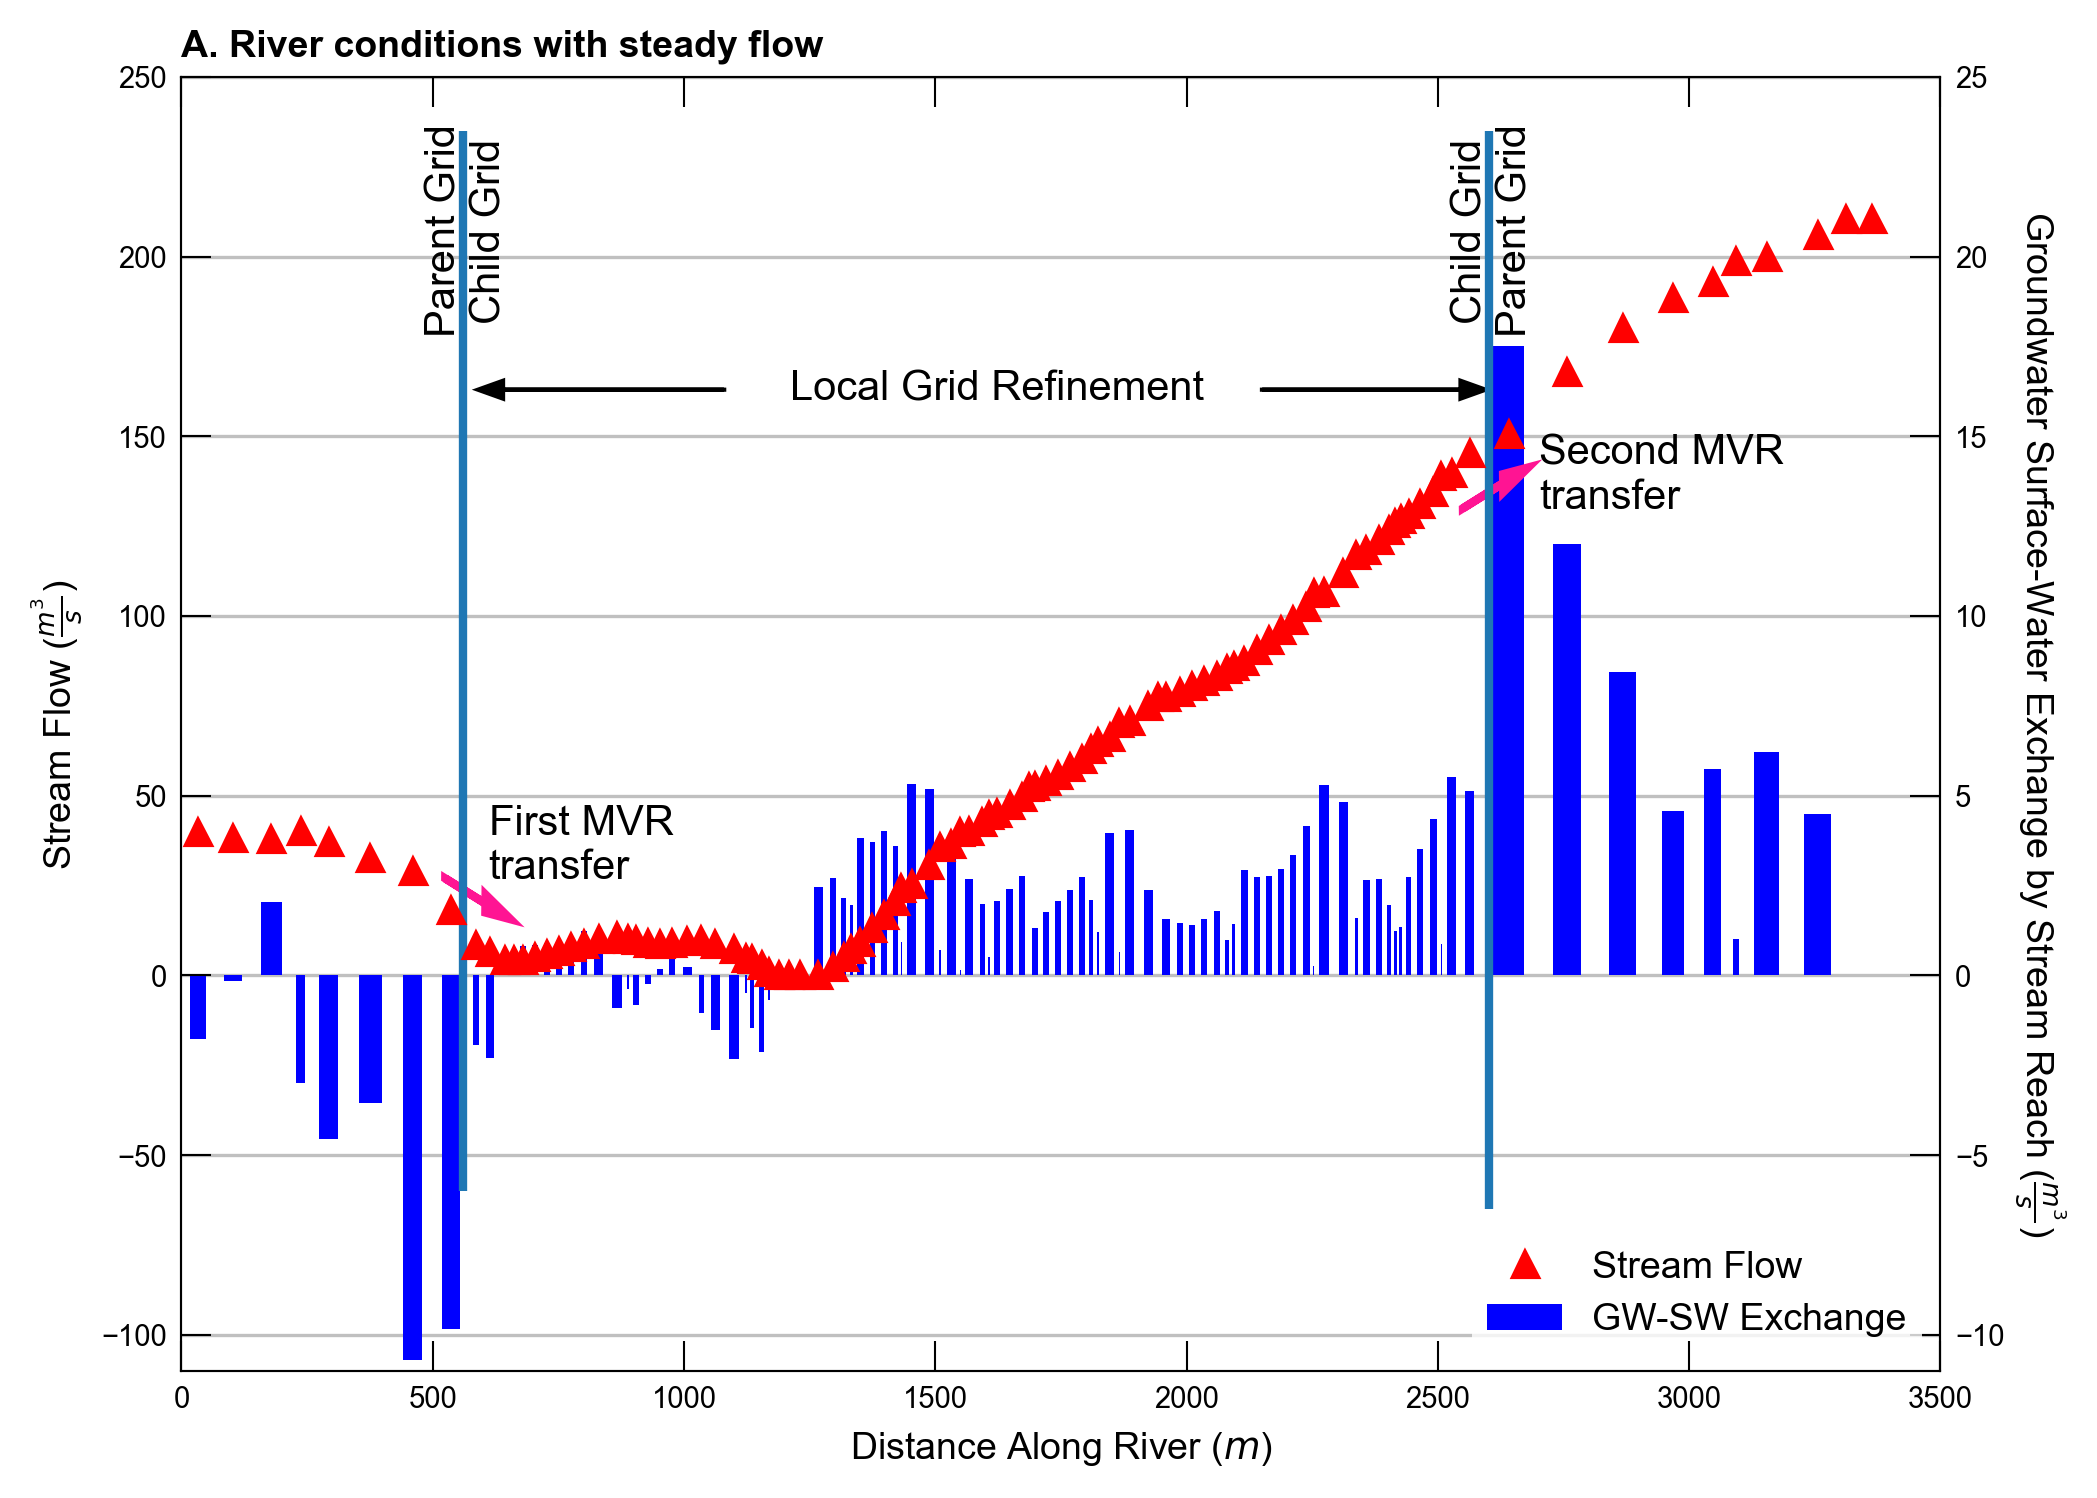

In [5]:
def scenario(idx, silent=True):
    sim = build_models(example_name)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(sim, idx)


# Two-dimensional transport in a uniform flow field
scenario(0)